# Hackin 3
- I think this is a good reference to hack through, even though it doesn't use gradients, will help me ground in something here!
- https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part41_indirect_object_identification/1.4.1_Indirect_Object_Identification_solutions.ipynb?t=20250330#scrollTo=y6MDKRsNKqpj

Eh maybe actually dis? 
https://colab.research.google.com/drive/13HDQ6o-TN7PcKCk4DlKgQ9O6jEeHbUW0?usp=sharing#scrollTo=U3JwUkOFATn-

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns

import llm_utils
# import opt_utils

In [5]:
import argparse
parser = argparse.ArgumentParser()
# the following demo is sutiable for gpt2 (all sizes),  OPT, GPT-j and Llama-2-7b
# we recommend on using gpt2 or OPT, since they have small versions that can be run without GPUs
parser.add_argument('--model_name', type=str, default='gpt2', help='model name (only models from HuggingFace that are supported by llm_utils)')
# parser.add_argument('--model_name', type=str, default='facebook/opt-350m', help='model name (only models from HuggingFace that are supported by llm_utils)')
parser.add_argument('--model_args', type=str, default='')
parser.add_argument('--disable_pad_token', action='store_true')
parser.add_argument('--device', type=str, default=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

_StoreAction(option_strings=['--device'], dest='device', nargs=None, const=None, default=device(type='cuda'), type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [6]:
args, unknown = parser.parse_known_args()
print('unknown args:', unknown)
print('args:', args)

unknown args: ['-f', '/home/stephen/.local/share/jupyter/runtime/kernel-bd715ae3-72db-41cf-b0bb-0484bb800b4b.json']
args: Namespace(model_name='gpt2', model_args='', disable_pad_token=False, device=device(type='cuda'))


In [7]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)
if not args.disable_pad_token:
    print(f'adding pad token: {tokenizer.eos_token}')
    tokenizer.pad_token = tokenizer.eos_token

try:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"  # not blocking, just to prevent warnings and faster tokenization
except:
    pass

adding pad token: <|endoftext|>


In [8]:
device = torch.device(args.device)
print(f'Using device: {device} [cuda available? => {torch.cuda.is_available()}, cuda version: {torch.version.cuda}, args.device = "{args.device}"]')

Using device: cuda [cuda available? => True, cuda version: 12.4, args.device = "cuda"]


In [9]:
model_extra_args = {}
for arg in args.model_args.split(','):
    if arg == '':
        continue
    k, v = arg.split('=')
    model_extra_args[k] = v
print(f'model_extra_args: {model_extra_args}')

model = AutoModelForCausalLM.from_pretrained(args.model_name, **model_extra_args).eval().requires_grad_(False).to(device)
model_aux = llm_utils.model_extra(model=model, device=device)
config = model_aux.config  # should be the same as auto_model_to_config(args.model_name)

n_embd = model_aux.n_embd
n_head = model_aux.n_head
head_size = model_aux.head_size
n_layer = model_aux.n_layer

model_extra_args: {}


AttributeError: module 'llm_utils' has no attribute 'model_extra'

---

In [1]:
import re
import sys
from functools import partial
from itertools import product
from pathlib import Path
from typing import Callable, Literal

import circuitsvis as cv
import einops
import numpy as np
import plotly.express as px
import torch as t
from IPython.display import HTML, display
from jaxtyping import Bool, Float, Int
from rich import print as rprint
from rich.table import Column, Table
from torch import Tensor
from tqdm.notebook import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.components import MLP, Embed, LayerNorm, Unembed
from transformer_lens.hook_points import HookPoint

t.set_grad_enabled(False)
device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# # Make sure exercises are in the path
# chapter = "chapter1_transformer_interp"
# section = "part41_indirect_object_identification"
# root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
# exercises_dir = root_dir / chapter / "exercises"
# section_dir = exercises_dir / section

# import part41_indirect_object_identification.tests as tests
# from plotly_utils import line # bar, imshow, line, scatter

# MAIN = __name__ == "__main__"

In [2]:
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

AssertionError: You can't refactor the QK circuit when using rotary embeddings (as the QK matrix depends on the position of the query and key)

In [4]:
# Here is where we test on a single prompt
# Result: 70% probability on Mary, as we expect

example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = " Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

In [5]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]

# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [prompt.format(name) for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1]]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = t.concat([model.to_tokens(names, prepend_bos=False).T for names in answers])

rprint(prompts)
rprint(answers)
rprint(answer_tokens)

table = Table("Prompt", "Correct", "Incorrect", title="Prompts & Answers:")

for prompt, answer in zip(prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))

rprint(table)

[
    'When John and Mary went to the shops, John gave the bag to',
    'When John and Mary went to the shops, Mary gave the bag to',
    'When Tom and James went to the park, James gave the ball to',
    'When Tom and James went to the park, Tom gave the ball to',
    'When Dan and Sid went to the shops, Sid gave an apple to',
    'When Dan and Sid went to the shops, Dan gave an apple to',
    'After Martin and Amy went to the park, Amy gave a drink to',
    'After Martin and Amy went to the park, Martin gave a drink to'
]

[
    (' Mary', ' John'),
    (' John', ' Mary'),
    (' Tom', ' James'),
    (' James', ' Tom'),
    (' Dan', ' Sid'),
    (' Sid', ' Dan'),
    (' Martin', ' Amy'),
    (' Amy', ' Martin')
]

tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')

                                   Prompts & Answers:                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Prompt                                                        ┃ Correct   ┃ Incorrect ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the bag to    │ ' Mary'   │ ' John'   │
│ When John and Mary went to the shops, Mary gave the bag to    │ ' John'   │ ' Mary'   │
│ When Tom and James went to the park, James gave the ball to   │ ' Tom'    │ ' James'  │
│ When Tom and James went to the park, Tom gave the ball to     │ ' James'  │ ' Tom'    │
│ When Dan and Sid went to the shops, Sid gave an apple to      │ ' Dan'    │ ' Sid'    │
│ When Dan and Sid went to the shops, Dan gave an apple to      │ ' Sid'    │ ' Dan'    │
│ After Martin and Amy went to the park, Amy gave a drink to    │ ' Martin' │ ' Amy'    │
│ After Martin and Amy went to the park, Martin gave a drink to │ ' Amy'    │ ' Martin' │
└───────────────────────────────────────────────────────────────┴───────────┴───────────┘

In [3]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# Move the tokens to the GPU
tokens = tokens.to(device)
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

NameError: name 'model' is not defined

In [7]:
def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False,
) -> Float[Tensor, "*batch"]:
    """
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    """
    # Only the final logits are relevant for the answer
    final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    # Get the logits corresponding to the indirect object / subject tokens respectively
    answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
    # Find logit difference
    correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
    answer_logit_diff = correct_logits - incorrect_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()


# tests.test_logits_to_ave_logit_diff(logits_to_ave_logit_diff)

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
    Column("Logit Difference", style="bold"),
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

Per prompt logit difference: tensor([3.3367, 3.2016, 2.7094, 3.7974, 1.7204, 5.2812, 2.6008, 5.7674],
       device='cuda:0')
Average logit difference: tensor(3.5519, device='cuda:0')


                                             Logit differences                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                                        ┃ Correct   ┃ Incorrect ┃ Logit Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the bag to    │ ' Mary'   │ ' John'   │ 3.337            │
│ When John and Mary went to the shops, Mary gave the bag to    │ ' John'   │ ' Mary'   │ 3.202            │
│ When Tom and James went to the park, James gave the ball to   │ ' Tom'    │ ' James'  │ 2.709            │
│ When Tom and James went to the park, Tom gave the ball to     │ ' James'  │ ' Tom'    │ 3.797            │
│ When Dan and Sid went to the shops, Sid gave an apple to      │ ' Dan'    │ ' Sid'    │ 1.720            │
│ When Dan and Sid went to the shops, Dan gave an apple to      │ ' Sid'    │ ' Dan'    │ 5.281            │
│ After Martin and Amy went to the park, Amy gave a drink to    │ ' Martin' │ ' Amy'    │ 2.601            │
│ After Martin and Amy went to the park, Martin gave a drink to │ ' Amy'    │ ' Martin' │ 5.767            │
└───────────────────────────────────────────────────────────────┴───────────┴───────────┴──────────────────┘

In [8]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)  # [batch 2 d_model]
print("Answer residual directions shape:", answer_residual_directions.shape)

correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions = correct_residual_directions - incorrect_residual_directions  # [batch d_model]
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([8, 2, 768])
Logit difference directions shape: torch.Size([8, 768])


In [9]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
final_residual_stream: Float[Tensor, "batch seq d_model"] = cache["resid_post", -1]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream: Float[Tensor, "batch d_model"] = final_residual_stream[:, -1, :]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer=-1, pos_slice=-1)

average_logit_diff = einops.einsum(
    scaled_final_token_residual_stream, logit_diff_directions, "batch d_model, batch d_model ->"
) / len(prompts)

print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

t.testing.assert_close(average_logit_diff, original_average_logit_diff)

Final residual stream shape: torch.Size([8, 15, 768])
Calculated average logit diff: 3.5518696308
Original logit difference:     3.5518684387


In [10]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of components in the
    residual stream.
    """
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return (
        einops.einsum(scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ...")
        / batch_size
    )


# Test function by checking that it gives the same result as the original logit difference
t.testing.assert_close(residual_stack_to_logit_diff(final_token_residual_stream, cache), original_average_logit_diff)

In [12]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float[Tensor, "component"] = residual_stack_to_logit_diff(accumulated_residual, cache)

# line(
#     logit_lens_logit_diffs,
#     hovermode="x unified",
#     title="Logit Difference From Accumulated Residual Stream",
#     labels={"x": "Layer", "y": "Logit Diff"},
#     xaxis_tickvals=labels,
#     width=800,
# )

In [13]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)


In [14]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)

Tried to stack head results when they weren't cached. Computing head results now


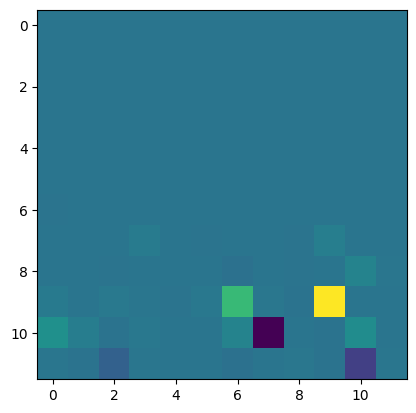

In [18]:
import matplotlib.pyplot as plt
plt.imshow(per_head_logit_diffs.detach().cpu().numpy())

In [21]:
def topk_of_Nd_tensor(tensor: Float[Tensor, "rows cols"], k: int):
    """
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    """
    i = t.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:
    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(per_head_logit_diffs * (1 if head_type == "Positive" else -1), k)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack(
        [cache["pattern", layer][:, head][0] for layer, head in top_heads]
    )

    # Display results
    display(HTML(f"<h2>Top {k} {head_type} Logit Attribution Heads</h2>"))
    display(
        cv.attention.attention_patterns(
            attention=attn_patterns_for_important_heads,
            tokens=model.to_str_tokens(tokens[0]),
            # attention_head_names=[f"{layer}.{head}" for layer, head in top_heads],
        )
    )

In [22]:
# cv.attention.attention_patterns?

In [23]:
top_heads

[[10, 7], [11, 10], [11, 2]]

In [1]:
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
import einops

In [2]:
device='cuda'

In [3]:
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-1B", device=device)

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


In [4]:
prompt = "The capital of France is"
answer = " Paris"
utils.test_prompt(prompt, answer, model)

Tokenized prompt: ['<|begin_of_text|>', 'The', ' capital', ' of', ' France', ' is']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 0        Logit: 18.43 Prob: 39.08% Token: | Paris|

Top 0th token. Logit: 18.43 Prob: 39.08% Token: | Paris|
Top 1th token. Logit: 16.89 Prob:  8.43% Token: | a|
Top 2th token. Logit: 16.71 Prob:  7.05% Token: | the|
Top 3th token. Logit: 15.89 Prob:  3.10% Token: | one|
Top 4th token. Logit: 15.88 Prob:  3.06% Token: | also|
Top 5th token. Logit: 15.69 Prob:  2.53% Token: | home|
Top 6th token. Logit: 15.66 Prob:  2.46% Token: | known|
Top 7th token. Logit: 15.27 Prob:  1.66% Token: | not|
Top 8th token. Logit: 14.98 Prob:  1.24% Token: | an|
Top 9th token. Logit: 14.92 Prob:  1.17% Token: | often|


Ranks of the answer tokens: [(' Paris', 0)]

In [5]:
text = "The capital of France is Paris"
tokens = model.to_tokens(text)
# logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)
original_logits, cache = model.run_with_cache(tokens)

In [6]:
cache['blocks.0.attn.hook_attn_scores'].shape

torch.Size([1, 32, 7, 7])

In [7]:
def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False,
) -> Float[Tensor, "*batch"]:
    """
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    """
    # Only the final logits are relevant for the answer
    final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    # Get the logits corresponding to the indirect object / subject tokens respectively
    answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
    # Find logit difference
    correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
    answer_logit_diff = correct_logits - incorrect_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()


tests.test_logits_to_ave_logit_diff(logits_to_ave_logit_diff)

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
    Column("Logit Difference", style="bold"),
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

NameError: name 'answer_tokens' is not defined

In [36]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of components in the
    residual stream.
    """
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return (
        einops.einsum(scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ...")
        / batch_size
    )


NameError: name 'logit_diff_directions' is not defined

In [24]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)

Tried to stack head results when they weren't cached. Computing head results now


In [26]:
per_head_residual.shape

torch.Size([512, 2048])

In [31]:
per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers)

In [33]:
per_head_residual.shape

torch.Size([16, 32, 2048])

In [34]:
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)

NameError: name 'residual_stack_to_logit_diff' is not defined

---

- Hmm may want to omit the BOS token, we'll see. 

In [10]:
cache['blocks.0.attn.hook_attn_scores'].detach().cpu()[0]

tensor([[ 1.1423,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 7.9602,  6.1469,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 7.4229,  7.5983,  5.2591,    -inf,    -inf,    -inf,    -inf],
        [ 9.6763, 11.3018,  8.9480,  7.3416,    -inf,    -inf,    -inf],
        [ 7.1744,  6.5851,  6.5272,  6.5630,  5.7304,    -inf,    -inf],
        [ 9.6897,  9.7189,  9.3344, 10.3011,  8.9203,  7.9233,    -inf],
        [ 7.1293,  4.9105,  5.1334,  5.6712,  6.1795,  6.0592,  5.5973]])

- Hmm so, becuase these suckers have been softmaxed, it's going to abe a little difficult to figure out which is "most imporrtant", right? Maybe this is where the gradients come in -> seems like the output attention matrix weights/activations/gradients could be pretty important here...
- Maybe we decouple looking at MLP vs attention temporarily. 

In [13]:
cache['blocks.0.mlp.hook_pre'].shape 

torch.Size([7, 8192])

In [14]:
cache['blocks.0.mlp.hook_pre_linear'].shape 

torch.Size([7, 8192])

In [15]:
cache['blocks.0.mlp.hook_post'].shape

torch.Size([7, 8192])

In [16]:
cache['blocks.0.hook_mlp_out'].shape

torch.Size([7, 2048])

In [18]:
keys=['blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out']
for k in keys: 
    print(k, cache[k].shape)

blocks.0.attn.hook_q torch.Size([7, 32, 64])
blocks.0.attn.hook_k torch.Size([7, 8, 64])
blocks.0.attn.hook_v torch.Size([7, 8, 64])
blocks.0.attn.hook_rot_q torch.Size([7, 32, 64])
blocks.0.attn.hook_rot_k torch.Size([7, 8, 64])
blocks.0.attn.hook_attn_scores torch.Size([32, 7, 7])
blocks.0.attn.hook_pattern torch.Size([32, 7, 7])
blocks.0.attn.hook_z torch.Size([7, 32, 64])
blocks.0.hook_attn_out torch.Size([7, 2048])


In [19]:
cache['blocks.0.attn.hook_pattern'].detach().cpu()[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8598, 0.1402, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4335, 0.5166, 0.0498, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1501, 0.7628, 0.0725, 0.0145, 0.0000, 0.0000, 0.0000],
        [0.3500, 0.1942, 0.1833, 0.1899, 0.0826, 0.0000, 0.0000],
        [0.1920, 0.1977, 0.1346, 0.3539, 0.0890, 0.0328, 0.0000],
        [0.4127, 0.0449, 0.0561, 0.0960, 0.1596, 0.1415, 0.0892]])

In [20]:
filtered_params = {name: p for name, p in model.named_parameters() if p.requires_grad}

In [23]:
filtered_params['blocks.0.attn.W_O'].shape

torch.Size([32, 64, 2048])

In [21]:
filtered_params.keys()

dict_keys(['embed.W_E', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_O', 'blocks.0.attn.b_Q', 'blocks.0.attn.b_O', 'blocks.0.attn._W_K', 'blocks.0.attn._W_V', 'blocks.0.attn._b_K', 'blocks.0.attn._b_V', 'blocks.0.mlp.W_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.W_gate', 'blocks.0.mlp.b_in', 'blocks.0.mlp.b_out', 'blocks.1.attn.W_Q', 'blocks.1.attn.W_O', 'blocks.1.attn.b_Q', 'blocks.1.attn.b_O', 'blocks.1.attn._W_K', 'blocks.1.attn._W_V', 'blocks.1.attn._b_K', 'blocks.1.attn._b_V', 'blocks.1.mlp.W_in', 'blocks.1.mlp.W_out', 'blocks.1.mlp.W_gate', 'blocks.1.mlp.b_in', 'blocks.1.mlp.b_out', 'blocks.2.attn.W_Q', 'blocks.2.attn.W_O', 'blocks.2.attn.b_Q', 'blocks.2.attn.b_O', 'blocks.2.attn._W_K', 'blocks.2.attn._W_V', 'blocks.2.attn._b_K', 'blocks.2.attn._b_V', 'blocks.2.mlp.W_in', 'blocks.2.mlp.W_out', 'blocks.2.mlp.W_gate', 'blocks.2.mlp.b_in', 'blocks.2.mlp.b_out', 'blocks.3.attn.W_Q', 'blocks.3.attn.W_O', 'blocks.3.attn.b_Q', 'blocks.3.attn.b_O', 'blocks.3.attn._W_K', 'blocks.3.attn._W_V', 'bloc